# TSP / Schedule Adherence

## Setup

In [1]:
import os
import sys
import logging
import warnings

root_path = os.path.abspath(f"{os.path.abspath('')}/../../..")

# Show INFO messages and supress auto-reload import warnings
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings("ignore")

In [2]:
# Libraries
sys.path.insert(0, f"{root_path}/CDFAndIoT/API")
sys.path.insert(0, f"{root_path}/TSP/ScheduleAdherence/Lambdas/StaticGtfs")
sys.path.insert(0, f"{root_path}/TSP/ScheduleAdherence/Service")
sys.path.insert(0, f"{root_path}/TSP/ScheduleAdherence/DataModel")

%pip install boto3 &> /dev/null
%pip install 'botocore[crt]' &> /dev/null
%pip install pydantic &> /dev/null
%pip install redis &> /dev/null
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Args
AGENCY_ID = "0537199e-e853-11ec-a8b8-f65b686c7d91"
TRIP_ID = "8802996-AUG22-Albany-Weekday-01"

In [4]:
import boto3
import json
import sqlalchemy
from sqlalchemy.pool import NullPool

from gtt.service.schedule_adherence import AuroraClient
from gtt.service.schedule_adherence.static_gtfs import StaticGtfsService

# Resources and services

# Athena SQL client (Depracated)
# athena = boto3.client("athena")
# sql_kwargs={"schema": "gtt_gd_gtfs_dev"},
# athena_client = AthenaClient(
#     athena, output_location="s3://aws-athena-query-results-083011521439-us-east-1/"
# )

# Aurora SQL client
secretsmanager = boto3.client("secretsmanager")

response = secretsmanager.get_secret_value(SecretId="develop/aurora/asmgtfs")
secret_dict = json.loads(response["SecretString"])

host = secret_dict["host"]
username = secret_dict["username"]
password = secret_dict["password"]
port = secret_dict["port"]

gtfs_conn = f"postgresql://{username}:{password}@{host}:{port}/gtfs"
aurora_engine = sqlalchemy.create_engine(gtfs_conn, poolclass=NullPool)

sql_client = AuroraClient(aurora_engine)
static_gtfs_service = StaticGtfsService(sql_client)

## Static GTFS Exploration

In [5]:
# Date
static_gtfs_date = static_gtfs_service.get_date(agency_id=AGENCY_ID)
print(static_gtfs_date)

2022-11-03 18:27:06.079420


In [6]:
# Stop
static_gtfs_stop = static_gtfs_service.get_stop(
    agency_id=AGENCY_ID, stop_id="390"
)

print(type(static_gtfs_stop))
print(static_gtfs_stop)

<class 'gtt.data_model.schedule_adherence.static_gtfs.StaticGtfsStop'>
stop_id='390' stop_name='Western Ave & Willow St' stop_lat=42.7043 stop_lon=-73.91145


In [7]:
# Stop times
static_gtfs_stop_times = static_gtfs_service.get_stop_times(
    agency_id=AGENCY_ID, trip_id=TRIP_ID, complete=False
)

print(type(static_gtfs_stop_times))
print(static_gtfs_stop_times[0:5])

<class 'list'>
[StaticGtfsStopTime(trip_id='8802996-AUG22-Albany-Weekday-01', stop_id='31', stop_sequence=1, arrival_time=datetime.time(6, 45), departure_time=datetime.time(6, 45), stop_headsign=None, pickup_type='0', drop_off_type='0', continuous_pickup=None, continuous_drop_off=None, shape_dist_traveled=None, timepoint=1, stop=None), StaticGtfsStopTime(trip_id='8802996-AUG22-Albany-Weekday-01', stop_id='10506', stop_sequence=2, arrival_time=datetime.time(6, 46), departure_time=datetime.time(6, 46), stop_headsign=None, pickup_type='0', drop_off_type='0', continuous_pickup=None, continuous_drop_off=None, shape_dist_traveled=None, timepoint=1, stop=None), StaticGtfsStopTime(trip_id='8802996-AUG22-Albany-Weekday-01', stop_id='10524', stop_sequence=3, arrival_time=datetime.time(6, 47), departure_time=datetime.time(6, 47), stop_headsign=None, pickup_type='0', drop_off_type='0', continuous_pickup=None, continuous_drop_off=None, shape_dist_traveled=None, timepoint=1, stop=None), StaticGtfsSt

In [8]:
# Stop times complete
static_gtfs_stop_times = static_gtfs_service.get_stop_times(
    agency_id=AGENCY_ID, trip_id=TRIP_ID
)

print(static_gtfs_stop_times[0:2])
print(static_gtfs_stop_times[0].stop)

[StaticGtfsStopTime(trip_id='8802996-AUG22-Albany-Weekday-01', stop_id='31', stop_sequence=1, arrival_time=datetime.time(6, 45), departure_time=datetime.time(6, 45), stop_headsign=None, pickup_type='0', drop_off_type='0', continuous_pickup=None, continuous_drop_off=None, shape_dist_traveled=None, timepoint=1, stop=StaticGtfsStop(stop_id='31', stop_name='Wolf Rd & Colonie Center', stop_lat=42.711386, stop_lon=-73.817806)), StaticGtfsStopTime(trip_id='8802996-AUG22-Albany-Weekday-01', stop_id='10506', stop_sequence=2, arrival_time=datetime.time(6, 46), departure_time=datetime.time(6, 46), stop_headsign=None, pickup_type='0', drop_off_type='0', continuous_pickup=None, continuous_drop_off=None, shape_dist_traveled=None, timepoint=1, stop=StaticGtfsStop(stop_id='10506', stop_name='Wolf Rd & Newbury Plaza', stop_lat=42.71389, stop_lon=-73.81383))]
stop_id='31' stop_name='Wolf Rd & Colonie Center' stop_lat=42.711386 stop_lon=-73.817806


In [9]:
# Trip
static_gtfs_trip = static_gtfs_service.get_trip(
    agency_id=AGENCY_ID, trip_id=TRIP_ID
)

print(type(static_gtfs_trip))
print(static_gtfs_trip)

<class 'gtt.data_model.schedule_adherence.static_gtfs.StaticGtfsTrip'>
route_id='1-196' service_id='AUG22-Albany-Weekday-01' trip_id='8802996-AUG22-Albany-Weekday-01' trip_headsign='Colonie Center to Downtown Albany' trip_short_name=None direction_id='0' block_id=None shape_id='10575' wheelchair_accessible='1' bikes_allowed='1' stops=None


## Schedule Adherence Scenarios

### Mock

In [10]:
from gtt.data_model.schedule_adherence import (
    VehiclePosition,
    ScheduleStatus,
    StaticGtfsStopTime,
    StaticGtfsStop,
    Schedule,
)

TRIP_ID = "trip-123_1223"

vehicle_position = VehiclePosition(
    latitude=42.345,
    longitude=101.123,
    vehicle_id="vehicle-123",
    trip_id=TRIP_ID,
    timestamp="2022-01-01 14:02:55.000"
)

static_gtfs_schedule = Schedule(
    stop_times=[
        StaticGtfsStopTime(
            trip_id=TRIP_ID,
            stop_id="stopid-1",
            stop_sequence=1,
            arrival_time="14:02:05",
            stop=StaticGtfsStop(
                stop_id="stopid-1",
                stop_name="Stop Num 1",
                stop_lat=42.34500002,
                stop_lon=101.12300003,
            ),
        ),
        StaticGtfsStopTime(
            trip_id=TRIP_ID,
            stop_id="stopid-2",
            stop_sequence=2,
            arrival_time="14:14:00",
            stop=StaticGtfsStop(
                stop_id="stopid-2",
                stop_name="Stop Num 2",
                stop_lat=42.34400002,
                stop_lon=101.12500003,
            ),
        ),
        StaticGtfsStopTime(
            trip_id=TRIP_ID,
            stop_id="stopid-3",
            stop_sequence=3,
            arrival_time="14:24:00",
            stop=StaticGtfsStop(
                stop_id="stopid-3",
                stop_name="Stop Num 3",
                stop_lat=42.34700002,
                stop_lon=101.12800003,
            ),
        ),
    ]
)

# Vehicle running late
schedule_status = ScheduleStatus.from_schedule(static_gtfs_schedule, vehicle_position)
print(schedule_status)

vehicle_position = VehiclePosition(
    latitude=42.34400002,
    longitude=101.12500003,
    vehicle_id="vehicle-123",
    trip_id=TRIP_ID,
    timestamp="2022-01-01 14:13:50.000"
)

# Vehicle running early
schedule_status = ScheduleStatus.from_schedule_status(static_gtfs_schedule, vehicle_position, schedule_status)
print(schedule_status)

vehicle_position = VehiclePosition(
    latitude=42.34700002,
    longitude=101.12800003,
    vehicle_id="vehicle-123",
    trip_id=TRIP_ID,
    timestamp="2022-01-01 14:24:00.000"
)

# Vehicle running on-time
schedule_status = ScheduleStatus.from_schedule_status(static_gtfs_schedule, vehicle_position, schedule_status)
print(schedule_status)

trip_id='trip-123_1223' vehicle_id='vehicle-123' delay=50.0 last_updated=datetime.datetime(2022, 11, 3, 18, 27, 6, 650805) next_update=datetime.datetime(2022, 1, 1, 14, 14, 50) next_stop=StaticGtfsStop(stop_id='stopid-2', stop_name='Stop Num 2', stop_lat=42.34400002, stop_lon=101.12500003) exact=True stop_events=[StopEvent(stop_id='stopid-1', timestamp=datetime.datetime(2022, 1, 1, 14, 2, 55))]
trip_id='trip-123_1223' vehicle_id='vehicle-123' delay=-10.0 last_updated=datetime.datetime(2022, 11, 3, 18, 27, 6, 651526) next_update=datetime.datetime(2022, 1, 1, 14, 23, 50) next_stop=StaticGtfsStop(stop_id='stopid-3', stop_name='Stop Num 3', stop_lat=42.34700002, stop_lon=101.12800003) exact=True stop_events=[StopEvent(stop_id='stopid-1', timestamp=datetime.datetime(2022, 1, 1, 14, 2, 55)), StopEvent(stop_id='stopid-2', timestamp=datetime.datetime(2022, 1, 1, 14, 13, 50))]
trip_id='trip-123_1223' vehicle_id='vehicle-123' delay=0.0 last_updated=datetime.datetime(2022, 11, 3, 18, 27, 6, 65197

In [11]:
from datetime import datetime
from gtt.data_model.schedule_adherence import ScheduleStatus, Schedule, VehiclePosition

# No context
vehicle_position = VehiclePosition(
    vehicle_id="123",
    trip_id="abc",
    latitude=43.1,
    longitude=123.1,
    stop_id="4015",
    timestamp='2022-09-07 06:43:00.000'
)
static_gtfs_schedule = Schedule(
    stop_times=static_gtfs_stop_times
)

schedule_status = ScheduleStatus.from_schedule(static_gtfs_schedule, vehicle_position)

print(schedule_status)
print(schedule_status.json())

trip_id='abc' vehicle_id='123' delay=-240.0 last_updated=datetime.datetime(2022, 11, 3, 18, 27, 6, 674128) next_update=datetime.datetime(2022, 9, 7, 6, 44) next_stop=StaticGtfsStop(stop_id='10525', stop_name='Sand Creek Rd & Central News', stop_lat=42.71445, stop_lon=-73.81004) exact=True stop_events=[StopEvent(stop_id='10524', timestamp=datetime.datetime(2022, 9, 7, 6, 43))]
{"trip_id": "abc", "vehicle_id": "123", "delay": -240.0, "last_updated": "2022-11-03T18:27:06.674128", "next_update": "2022-09-07T06:44:00", "next_stop": {"stop_id": "10525", "stop_name": "Sand Creek Rd & Central News", "stop_lat": 42.71445, "stop_lon": -73.81004}, "exact": true, "stop_events": [{"stop_id": "10524", "timestamp": "2022-09-07T06:43:00"}]}


In [12]:
# With context
vehicle_position = VehiclePosition(
    vehicle_id="123",
    trip_id="abc",
    latitude=43.1,
    longitude=123.1,
    stop_id="6294",
    timestamp="2022-09-07 06:47:00.000",
)
schedule_status = ScheduleStatus.from_schedule_status(
    static_gtfs_schedule, vehicle_position, schedule_status
)

print(schedule_status)

trip_id='abc' vehicle_id='123' delay=-60.0 last_updated=datetime.datetime(2022, 11, 3, 18, 27, 6, 691187) next_update=datetime.datetime(2022, 9, 7, 6, 49) next_stop=StaticGtfsStop(stop_id='10522', stop_name='80 Wolf Rd', stop_lat=42.714879, stop_lon=-73.812553) exact=True stop_events=[StopEvent(stop_id='10524', timestamp=datetime.datetime(2022, 9, 7, 6, 43)), StopEvent(stop_id='10525', timestamp=datetime.datetime(2022, 9, 7, 6, 47))]


### Live

In [13]:
TRIP_ID = "8802996-AUG22-Albany-Weekday-01"

In [14]:
# Schedule Adherence service
from gtt.service.schedule_adherence import ScheduleAdherenceService
from redis import Redis

# REDIS_URL = "cluster-tsp-tsptest.ibjafd.0001.use1.cache.amazonaws.com"
REDIS_URL = "10.0.0.38"
REDIS_PORT = "6379"

# REDIS_URL="localhost"
# REDIS_PORT="7001"

REDIS_USERNAME = None
REDIS_PASSWORD = None

redis = Redis(
    host=REDIS_URL,
    port=REDIS_PORT,
    ssl=False,
    db=0,
    decode_responses=True,
)

schedule_adherence_service = ScheduleAdherenceService(
    redis,
    static_gtfs_service
)

In [15]:
# Check connection
redis.ping()

True

In [16]:
for key in sorted(redis.scan_iter("*")):
    print(key)

*:vehicle_position:veh-123
rt_radio_message:device_fields:tsptest-gtfs-realtime-2
rt_radio_message:device_fields:tsptest-gtfs-realtime-3
rt_radio_message:device_fields:tsptest-gtfs-realtime-4
rt_radio_message:tsptest-gtfs-realtime-1:payload
rt_radio_message:tsptest-gtfs-realtime-1:topic
rt_radio_message:tsptest-gtfs-realtime-2:payload
rt_radio_message:tsptest-gtfs-realtime-2:topic
rt_radio_message:tsptest-gtfs-realtime-3:payload
rt_radio_message:tsptest-gtfs-realtime-3:topic
rt_radio_message:tsptest-gtfs-realtime-4:payload
rt_radio_message:tsptest-gtfs-realtime-4:topic
tsp_in_cloud:static_gtfs:0537199e-e853-11ec-a8b8-f65b686c7d91:stop_times:8802996-AUG22-Albany-Weekday-01
tsp_in_cloud:static_gtfs:test_agency:stop_times:10536292
tsp_in_cloud:trip_delay:0537199e-e853-11ec-a8b8-f65b686c7d91:8802996-AUG22-Albany-Weekday-01:vehicle-123
tsp_in_cloud:trip_delay:test_agency:10536292:vehicle-a
tsp_in_cloud:tsp_enabled:0537199e-e853-11ec-a8b8-f65b686c7d91
tsp_in_cloud:tsp_in_cloud:set_tsp_enable

In [17]:
# Caching
# schedule_adherence_service.clear_schedule_status(AGENCY_ID)
# schedule_adherence_service.invalidate(AGENCY_ID)
cached_schedule_status = schedule_adherence_service.get_schedule_status(
    AGENCY_ID, TRIP_ID, "vehicle-123"
)
print(cached_schedule_status)

vehicle_position = VehiclePosition(
    latitude=42.34400002,
    longitude=101.12500003,
    vehicle_id="vehicle-123",
    trip_id=TRIP_ID,
    timestamp="2022-01-01 14:13:50.000",
)

schedule_adherence_service.update_schedule_status(AGENCY_ID, vehicle_position)

cached_schedule_status = schedule_adherence_service.get_schedule_status(
    AGENCY_ID, TRIP_ID, "vehicle-123"
)
print(cached_schedule_status)

# Successive calls
vehicle_position = VehiclePosition(
    latitude=42.34400002,
    longitude=101.12500003,
    vehicle_id="vehicle-123",
    trip_id=TRIP_ID,
    timestamp="2022-01-01 14:15:50.000",
)

schedule_status = schedule_adherence_service.update_schedule_status(
    AGENCY_ID, vehicle_position
)
# Additional stop event
print(schedule_status)

schedule_status = schedule_adherence_service.update_schedule_status(
    AGENCY_ID, vehicle_position
)

# Should be 'None' after second call (no update)
print(schedule_status)

schedule_status = schedule_adherence_service.get_schedule_status(
    AGENCY_ID, vehicle_position.trip_id, vehicle_position.vehicle_id
)

# Must get it manually
print(schedule_status)

trip_id='8802996-AUG22-Albany-Weekday-01' vehicle_id='vehicle-123' delay=26570.0 last_updated=datetime.datetime(2022, 11, 3, 18, 25, 29, 49575) next_update=datetime.datetime(2022, 1, 1, 14, 15, 50) next_stop=StaticGtfsStop(stop_id='32', stop_name='32 Wolf Rd (Bed Bath and Beyond)', stop_lat=42.71094, stop_lon=-73.81892) exact=True stop_events=[StopEvent(stop_id='10524', timestamp=datetime.datetime(2022, 1, 1, 14, 13, 50)), StopEvent(stop_id='10525', timestamp=datetime.datetime(2022, 1, 1, 14, 15, 50)), StopEvent(stop_id='10522', timestamp=datetime.datetime(2022, 1, 1, 14, 15, 50)), StopEvent(stop_id='10523', timestamp=datetime.datetime(2022, 1, 1, 14, 13, 50))]
trip_id='8802996-AUG22-Albany-Weekday-01' vehicle_id='vehicle-123' delay=26450.0 last_updated=datetime.datetime(2022, 11, 3, 18, 27, 6, 816092) next_update=datetime.datetime(2022, 1, 1, 14, 15, 50) next_stop=StaticGtfsStop(stop_id='10514', stop_name='Colonie Station - Central Ave & Northway Mall', stop_lat=42.706703, stop_lon=-7

### Scenarios



In [18]:
from util.scenarios import Scenario, LocalStaticGtfsService
from util.fixtures import TEST_BASIC, STOP_TIMES_BASIC, SCHEDULE_STATUS_BASIC

schedule_status = ScheduleStatus(**SCHEDULE_STATUS_BASIC)
schedule = Schedule(stop_times=STOP_TIMES_BASIC)
scenario = Scenario(TEST_BASIC)

local_static_gtfs_service = LocalStaticGtfsService(
    scenario.date,
    scenario.stops,
    scenario.trip_stop_times
)

scenario_schedule_adherence_service = ScheduleAdherenceService(
    redis, local_static_gtfs_service
)

In [19]:
%pip install pandas &> /dev/null
%pip install matplotlib &> /dev/null

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import json

stops = pd.DataFrame(
    json.loads(StaticGtfsStop.__config__.json_dumps(
        scenario.stops, default=StaticGtfsStop.__json_encoder__
    )),
    columns=["stop_id", "stop_lat", "stop_lon"]
)
stops.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,stop_id,stop_lat,stop_lon
0,7765,37.771146,-122.389936
1,7766,37.770513,-122.391037
2,7324,37.768710,-122.389377
3,7767,37.766864,-122.390891
4,7865,37.766722,-122.392805


In [21]:
print(schedule_status)
ss = pd.DataFrame(
    json.loads(
        ScheduleStatus.__config__.json_dumps(
            [schedule_status], default=ScheduleStatus.__json_encoder__
        )
    ),
    columns=[
        "delay",
        "last_updated",
        "next_update",
        "next_stop",
        "exact",
        "stop_events",
    ],
)


def extract_stop_event_info(ss, stops):
    for index, row in ss.iterrows():
        if len(row["stop_events"]) <= 0:
            return row

        latest_stop_event = row["stop_events"][-1]
        latest_stop = next(
            filter(lambda x: x.stop_id == latest_stop_event["stop_id"], stops), None
        )

        ss.at[index, "latitude"] = latest_stop.stop_lat
        ss.at[index, "longitude"] = latest_stop.stop_lon

    return ss


extract_stop_event_info(ss, scenario.stops).head()

trip_id='10536292' vehicle_id='ve' delay=20.0 last_updated=None next_update=None next_stop=None exact=False stop_events=[StopEvent(stop_id='7765', timestamp=datetime.datetime(2022, 10, 30, 9, 18, 40))]


,delay,last_updated,next_update,next_stop,exact,stop_events,latitude,longitude
0,20.0,None,None,None,False,"[{'stop_id': '7765', 'timestamp': '2022-10-30T...",37.771146,-122.389936


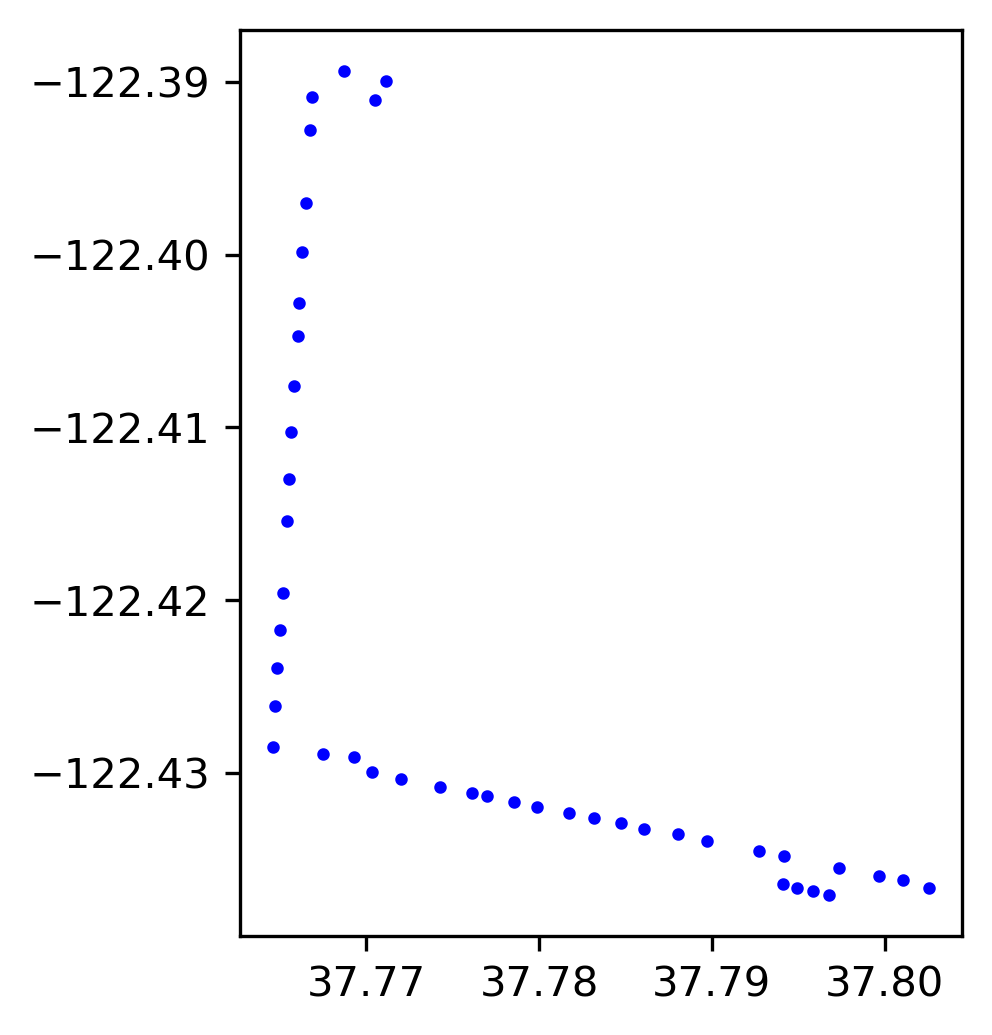

In [22]:
import matplotlib.pyplot as plt


def plot_scenario(scenario, vehicle_positions=[], schedule_statuses=[]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_dpi(300)

    stops = pd.DataFrame(
        json.loads(
            StaticGtfsStop.__config__.json_dumps(
                scenario.stops, default=StaticGtfsStop.__json_encoder__
            )
        ),
        columns=["stop_id", "stop_lat", "stop_lon"],
    )

    ax.scatter(x=stops["stop_lat"], y=stops["stop_lon"], c="blue", s=4)

    if len(vehicle_positions) > 0:
        vp = pd.DataFrame(
            json.loads(
                ScheduleStatus.__config__.json_dumps(
                    vehicle_positions, default=ScheduleStatus.__json_encoder__
                )
            ),
            columns=["latitude", "longitude"],
        )

        ax.scatter(x=vp["latitude"], y=vp["longitude"], c="red", s=3, alpha=0.2)

    if len(schedule_statuses) > 0:
        ss = pd.DataFrame(
            json.loads(
                ScheduleStatus.__config__.json_dumps(
                    schedule_statuses, default=ScheduleStatus.__json_encoder__
                )
            ),
            columns=[
                "delay",
                "last_updated",
                "next_update",
                "next_stop",
                "exact",
                "stop_events",
            ],
        )
        ss = extract_stop_event_info(ss, scenario.stops)

        ax.scatter(x=ss["latitude"], y=ss["longitude"], c="green", s=3)

    ax.set_aspect("equal", adjustable="box")

    plt.show()


plot_scenario(scenario)

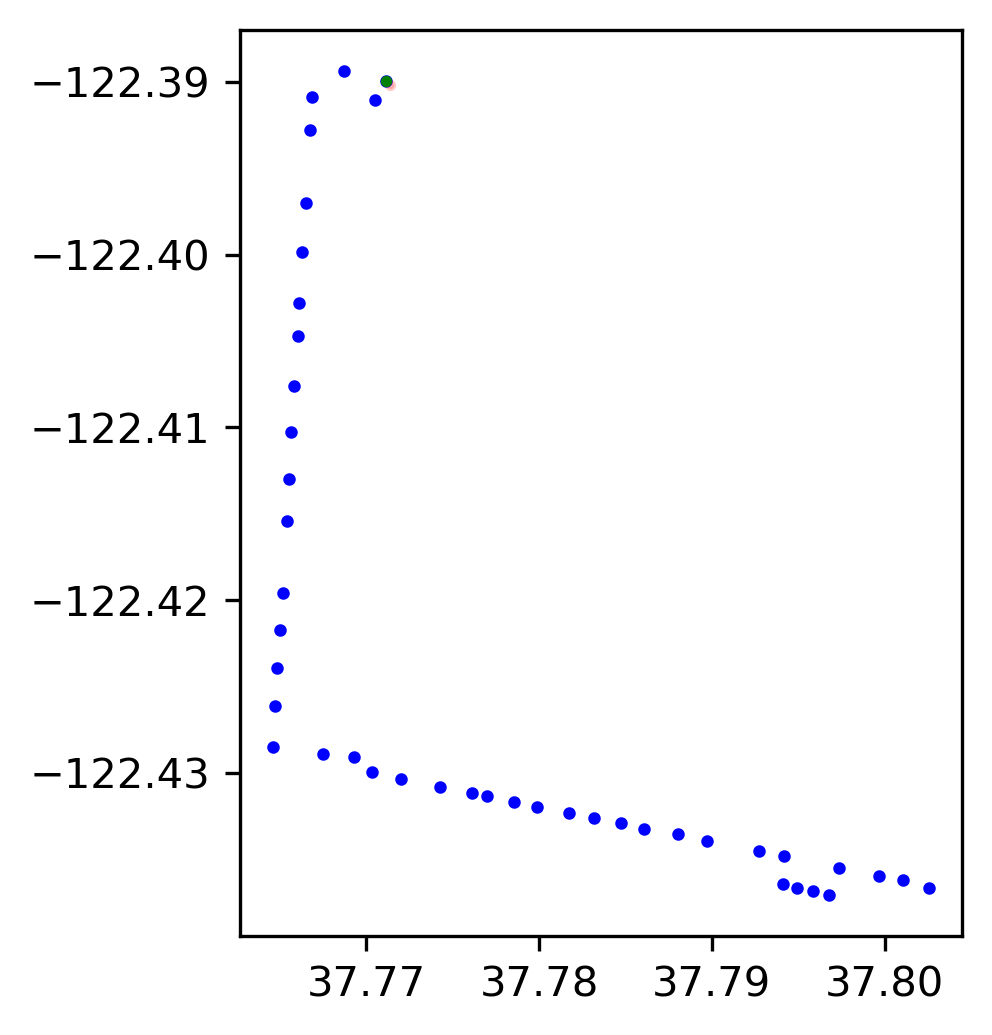

In [23]:
from gtt.data_model.schedule_adherence import StopEvent

plot_scenario(
    scenario,
    vehicle_positions=[
        VehiclePosition(
            vehicle_id="test",
            trip_id="test",
            timestamp="2022-09-01 12:01:01",
            latitude=37.771346,
            longitude=-122.39016,
        )
    ],
    schedule_statuses=[
        ScheduleStatus(
            trip_id="test",
            vehicle_id="test",
            delay=10,
            stop_events=[
                StopEvent(stop_id="7765", timestamp="2022-09-01 12:00:20")
            ]
        )
    ]
)

In [24]:
from itertools import islice

agency_id = scenario.agency_id
vehicle_id = next(iter(scenario.vehicle_ids))
trip_id = next(iter(scenario.trip_ids))

# NUM_POINTS = 1500
START = 1000
NUM_POINTS = 5

scenario_schedule_adherence_service.invalidate(agency_id)

for i, vehicle_position in enumerate(islice(scenario, START + NUM_POINTS)):
    if (i < START or i > (START + NUM_POINTS)):
        continue

    scenario_schedule_adherence_service.update_schedule_status(agency_id, vehicle_position)

    print(
        "CACHE",
        scenario_schedule_adherence_service.get_schedule_status(
            agency_id=agency_id,
            trip_id=trip_id,
            vehicle_id=vehicle_id,
        ),
    )

In [25]:
from util.fixtures import TEST_WHOLE_ROUTE

scenario = Scenario(TEST_WHOLE_ROUTE)

local_static_gtfs_service = LocalStaticGtfsService(
    scenario.date,
    scenario.stops,
    scenario.trip_stop_times
)

scenario_schedule_adherence_service = ScheduleAdherenceService(
    redis, local_static_gtfs_service
)

In [26]:
# Freeze the current time
%pip install freezegun

from freezegun import freeze_time

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


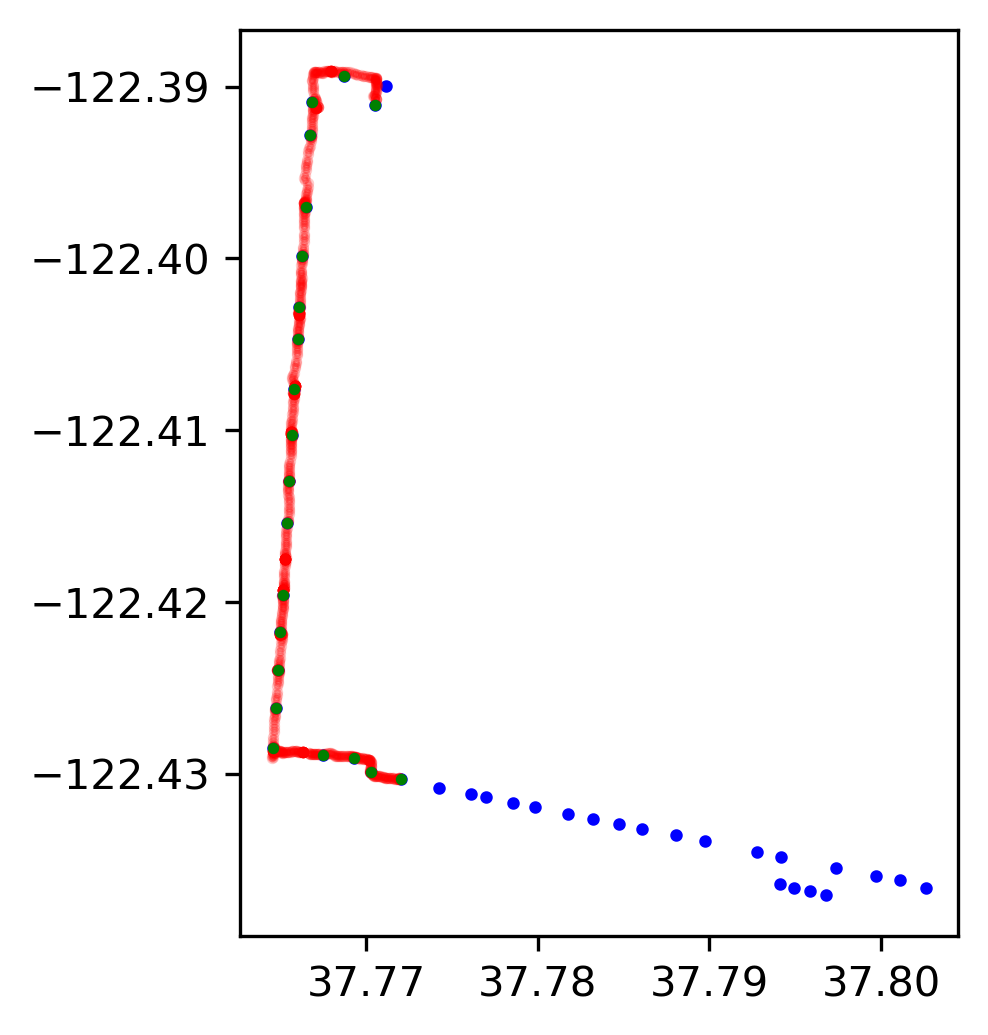

In [27]:
from itertools import islice

# NUM_POINTS = 1500
START = 1000
NUM_POINTS = 1000

scenario_schedule_adherence_service.invalidate(agency_id)
schedule_statuses = []
used_vehicle_positions = []
cached_schedule_status = None

with freeze_time("2022-04-03 08:59:11") as frozen_datetime:
    for i, vehicle_position in enumerate(islice(scenario, START + NUM_POINTS)):
        if (
            i < START or i > (START + NUM_POINTS)
            or abs(vehicle_position.latitude) < 1
            or abs(vehicle_position.longitude) < 1
        ):
            continue

        frozen_datetime.move_to(vehicle_position.timestamp)

        used_vehicle_positions.append(vehicle_position)

        if (
            cached_schedule_status is not None
            and cached_schedule_status.next_update is not None
            and (
                (cached_schedule_status.next_update - datetime.now()).total_seconds()
                > 10
                # May also check for proximity to next stop
            )
        ):
            continue

        cached_schedule_status = scenario_schedule_adherence_service.update_schedule_status(
            agency_id, vehicle_position
        )

        if cached_schedule_status is not None:
            schedule_statuses.append(cached_schedule_status)

plot_scenario(
    scenario,
    schedule_statuses=schedule_statuses,
    vehicle_positions=used_vehicle_positions,
)

In [28]:
print(f"Number of events: {len(schedule_statuses)}\n")

for schedule_status in schedule_statuses:
    print(schedule_status.to_string())
    print(schedule_status.latest_stop_event)
    print('')

Number of events: 21

Delay: 4.919s Early
Last Updated: 2022-04-03 09:19:29.081000
Next Update: 2022-04-03 09:20:35.081000
Number of Stop Events: 1
Latest Stop ID: 7766
Next Stop ID: 7324
stop_id='7766' timestamp=datetime.datetime(2022, 4, 3, 9, 19, 29, 81000)

Delay: 14.871s Early
Last Updated: 2022-04-03 09:20:25.129000
Next Update: 2022-04-03 09:21:44.129000
Number of Stop Events: 2
Latest Stop ID: 7324
Next Stop ID: 7767
stop_id='7324' timestamp=datetime.datetime(2022, 4, 3, 9, 20, 25, 129000)

Delay: 24.1s Early
Last Updated: 2022-04-03 09:21:34.900000
Next Update: 2022-04-03 09:22:08.900000
Number of Stop Events: 3
Latest Stop ID: 7767
Next Stop ID: 7865
stop_id='7767' timestamp=datetime.datetime(2022, 4, 3, 9, 21, 34, 900000)

Delay: 33.226s Early
Last Updated: 2022-04-03 09:21:59.774000
Next Update: 2022-04-03 09:23:14.774000
Number of Stop Events: 4
Latest Stop ID: 7865
Next Stop ID: 7768
stop_id='7865' timestamp=datetime.datetime(2022, 4, 3, 9, 21, 59, 774000)

Delay: 43.215s

### Headway

In [29]:
# Not implemented...

## API

### Static GTFS

In [30]:
os.environ["REDIS_URL"] = REDIS_URL
os.environ["REDIS_PORT"] = REDIS_PORT
os.environ["REDIS_USERNAME"] = REDIS_USERNAME or ""
os.environ["REDIS_PASSWORD"] = REDIS_PASSWORD or ""

In [31]:
from app import handler
from models import InvalidateStaticGtfsHttpRequest

from datetime import datetime
from typing import List

# Invalidate static GTFS. Invalidate static GTFS
event = InvalidateStaticGtfsHttpRequest(
    **{
        "requestContext": {},
        "queryStringParameters": {"agencyId": "sfmta"},
        "pathParameters": {"endpoint": "invalidate"},
        "requestContext": {"httpMethod": "POST"},
        "httpMethod": "POST"
    }
)

handler(event.dict(by_alias=True), {})

INFO:root:Received event={'headers': None, 'body': None, 'queryStringParameters': {'agencyId': 'sfmta'}, 'pathParameters': {'endpoint': 'invalidate'}, 'requestContext': {'httpMethod': 'POST'}, 'httpMethod': 'POST', 'path': None, 'resourcePath': None, 'identity': None, 'data': <class 'pydantic.main.Data'>}, context={}
INFO:root:Invalidating static GTFS on channel tsp_in_cloud:invalidate_static_gtfs:sfmta:all:*
INFO:root:Status Code: 200 Body: 0 


{'statusCode': 200,
 'body': '0',
 'headers': {'Content-Type': 'application/json',
  'Access-Control-Allow-Origin': '*'}}

In [32]:
from models import InvalidateStaticGtfsEventRequest

# EventBridge static event. Invalidate static GTFS
event = InvalidateStaticGtfsEventRequest(
    detail={ "endpoint": "invalidate", "agency_id": "sfmta" }
)

handler(event.dict(by_alias=True), {})

INFO:root:Received event={'detail': {'agencyId': 'sfmta', 'endpoint': 'invalidate'}}, context={}
INFO:root:Invalidating static GTFS on channel tsp_in_cloud:invalidate_static_gtfs:sfmta:all:*
INFO:root:Status Code: 200 Body: 0 


{'statusCode': 200,
 'body': '0',
 'headers': {'Content-Type': 'application/json',
  'Access-Control-Allow-Origin': '*'}}

## Manager

In [33]:
sys.path.insert(0, f"{root_path}/TSP/tsp-gtfs-realtime/tsp_gtfs_realtime")
sys.path.insert(0, f"{root_path}/CDFAndIoT/Service/AssetLibrary")
sys.path.insert(0, f"{root_path}/CDFAndIoT/DataModel/AssetLibrary")

In [34]:
%pip install requests_aws_sign

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [35]:
from time import sleep
from gtt.data_model.schedule_adherence.static_gtfs import StaticGtfsChannel
from schedule_adherence_manager import (
    main,
    VehiclePositionsChannel,
    ScheduleAdherenceManager,
)
from redis import Redis
import os

redis = Redis(os.getenv("REDIS_URL"), int(os.getenv("REDIS_PORT")))

freezer = freeze_time("2022-09-01 12:01:03.000")
freezer.start()

main(
    agency_id="sfmta",
    aurora_secret_name="develop/aurora/asmgtfs"
)

for [timestamp, latitude, longitude] in [
    ("2022-09-01 12:01:02.000", 43.3, 123.3),
    ("2022-09-01 12:01:03.000", 43.3, 123.3),
    ("2022-09-01 12:01:04.000", 43.3, 123.3),
]:
    sleep(1)
    redis.set(
        VehiclePositionsChannel.cache(
            agency_id="sfmta", vehicle_id="veh-123"
        ),
        VehiclePosition(
            trip_id="10536290",
            vehicle_id="veh-123",
            timestamp=timestamp,
            latitude=latitude,
            longitude=longitude
        ).json(),
    )

    redis.publish(
        VehiclePositionsChannel.new(
            agency_id="sfmta", vehicle_id="veh-123"
        ),
        "",
    )

freezer.stop()

# redis.publish(
#     StaticGtfsChannel.invalidate(agency_id="sfmta"),
#     "",
# )

INFO:root:Starting service
INFO:root:Connecting to Redis instance: 10.0.0.38:6379
INFO:root:Connected to Redis
INFO:root:Running for agency_id='sfmta'


ClientError: An error occurred (InvalidSignatureException) when calling the GetSecretValue operation: Signature expired: 20220901T120103Z is now earlier than 20221103T182221Z (20221103T182721Z - 5 min.)